In [112]:
import os

#TRAIN_DATA = os.path.join('..', 'data', 'processed', 'train.csv')
TRAIN_DATA = os.path.join('..', 'data', 'processed', 'train_balanced.csv')
TEST_DATA = os.path.join('..', 'data', 'processed', 'test.csv')

FEATURES_IT1 = [
    'GyroscopeStat_x_MEAN',
    'GyroscopeStat_z_MEAN',
    'GyroscopeStat_COV_z_x',
    'GyroscopeStat_COV_z_y',
    'MagneticField_x_MEAN',
    'MagneticField_z_MEAN',
    'MagneticField_COV_z_x',
    'MagneticField_COV_z_y',
    'Pressure_MEAN',
    'LinearAcceleration_COV_z_x',
    'LinearAcceleration_COV_z_y',
    'LinearAcceleration_x_MEAN',
    'LinearAcceleration_z_MEAN',
]
FEATURES_IT2 = FEATURES_IT1
FEATURES_IT3 = [
    'GyroscopeStat_x_MEAN',
    'GyroscopeStat_z_MEAN',
    'GyroscopeStat_COV_z_x',
    'GyroscopeStat_COV_z_y',
    #'MagneticField_x_MEAN',
    #'MagneticField_z_MEAN',
    #'MagneticField_COV_z_x',
    #'MagneticField_COV_z_y',
    #'Pressure_MEAN',
    'LinearAcceleration_COV_z_x',
    'LinearAcceleration_COV_z_y',
    'LinearAcceleration_x_MEAN',
    'LinearAcceleration_z_MEAN',
]

## 1. Load dataset

In [113]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

df_train = sqlCtx.read.load(TRAIN_DATA,
                     format='com.databricks.spark.csv', header='true',
                     inferSchema='true')
df_test = sqlCtx.read.load(TEST_DATA,
                     format='com.databricks.spark.csv', header='true',
                     inferSchema='true')

In [114]:
FEATURES = FEATURES_IT3

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=FEATURES, outputCol='features')
X_train = assembler.transform(df_train)
X_test = assembler.transform(df_test)

X_train.columns

['UserID',
 'UUID',
 'Version',
 'TimeStemp',
 'GyroscopeStat_x_MEAN',
 'GyroscopeStat_z_MEAN',
 'GyroscopeStat_COV_z_x',
 'GyroscopeStat_COV_z_y',
 'MagneticField_x_MEAN',
 'MagneticField_z_MEAN',
 'MagneticField_COV_z_x',
 'MagneticField_COV_z_y',
 'Pressure_MEAN',
 'LinearAcceleration_COV_z_x',
 'LinearAcceleration_COV_z_y',
 'LinearAcceleration_x_MEAN',
 'LinearAcceleration_z_MEAN',
 'attack',
 'features']

In [115]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='attack', featuresCol='features',
                           maxDepth=2, minInstancesPerNode=20,
                           impurity='gini')

In [116]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[dt])
model = pipeline.fit(X_train)

In [117]:
predictions = model.transform(X_test)

In [118]:
predictions.select('prediction', 'attack').show(10)

+----------+------+
|prediction|attack|
+----------+------+
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       0.0|     1|
|       0.0|     1|
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 10 rows



In [120]:
OUTPUT = os.path.join('..', 'report', 'it3', 'dt_predictions')

predictions.select('prediction', 'attack').write.save(
    path=OUTPUT,
    format='com.databricks.spark.csv', header='true')

In [121]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='attack',
                                            predictionCol='prediction',
                                            metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy:', accuracy)

Accuracy: 0.9190456769983687


In [122]:
predictions = predictions.select('prediction', predictions.attack.cast('double').alias('attack'))
predictions.rdd.take(2)

[Row(prediction=1.0, attack=1.0), Row(prediction=1.0, attack=1.0)]

In [123]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictions.rdd.map(tuple))
metrics.confusionMatrix().toArray().transpose()

array([[4.501e+03, 2.000e+00],
       [3.950e+02, 6.000e+00]])

In [124]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.9193219 0.0806781]
 [0.25      0.75     ]]


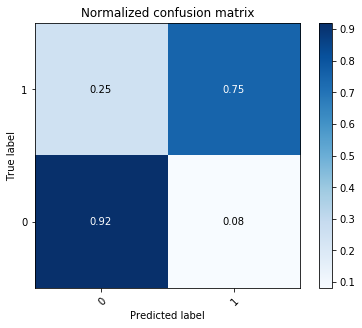

In [126]:
IMG_OUTPUT = os.path.join('..', 'report', 'it3', 'images')
os.makedirs(IMG_OUTPUT, exist_ok=True)

y_true = [int(row.attack) for row in predictions.select('attack').collect()]
y_pred = [int(row.prediction) for row in predictions.select('prediction').collect()]

plot_confusion_matrix(y_true, y_pred,
                      classes = unique_labels(y_true, y_pred),
                      normalize=True,
                      title='Normalized confusion matrix')

plt.ylim((-0.5, 1.5))

plt.savefig(os.path.join(IMG_OUTPUT, 'dt_confusion_matrix.png'))